In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy import stats
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error, mean_absolute_error, recall_score, make_scorer
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.metrics import Recall, Precision
import keras.backend as K
import tensorflow as tf
# Set a fixed seed value for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

warnings.filterwarnings('ignore')

# Get the data

The dataset for this research project is derived from a non-machine-learning study titled "The Population Biology of Abalone (Haliotis species) in Tasmania. I. Blacklip Abalone (H. rubra) from the North Coast and Islands of Bass Strait" by Warwick J Nash and colleagues (1994). The goal of the project is to predict whether an abalone is old or young using physical and biological attributes. The dataset contains 4177 observations and 8 features, including a categorical feature for sex (male, female, or infant) and 7 numeric features describing the size and weight of the abalone.

## Load the data

In [2]:
data = pd.read_csv("../data/abalone_age/abalone.csv")

In [3]:
data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


# EDA

## Distribution of target variable

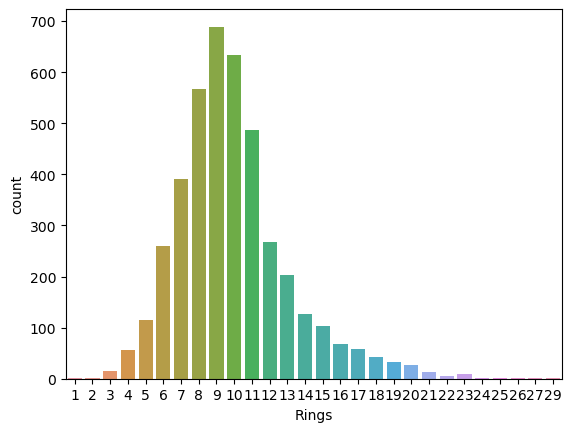

In [4]:
sns.countplot(x='Rings', data = data)

# Save and show the plot
plt.savefig('../eda/abalone_age/target_var_distribution.png')
plt.show()

## Possible missing values

In [5]:
# check for missing values

missing_values = data.isnull().sum().sort_values(ascending = False)
percentage_missing_values = (missing_values/len(data))*100
pd.concat([missing_values, percentage_missing_values], axis = 1, keys= ['Missing values', '% Missing'])

,Missing values,% Missing
Sex,0,0.0
Length,0,0.0
Diameter,0,0.0
Height,0,0.0
Whole weight,0,0.0
Shucked weight,0,0.0
Viscera weight,0,0.0
Shell weight,0,0.0
Rings,0,0.0


In [6]:
data.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


It seems like there are minimum values in Height that are 0

In [7]:
data[data.Height == 0]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


There are two instances in the records where the value for "Height" is equal to 0. It is possible that this value was difficult to measure accurately or was simply omitted. However, given that there are only two such instances, it may be appropriate remove them from the dataset completely. This issue will be addressed later, after the split to avoid data leakage.

## Search for outliers

In [8]:
numeric_features = data.select_dtypes(include=[np.number]).columns

In [9]:
skewness = stats.skew(data[numeric_features])
skewness_data = pd.concat([pd.DataFrame(numeric_features, columns=['Features']),pd.DataFrame(skewness,columns=['Skewness'])],axis = 1)
skewness_data.sort_values(by='Skewness', ascending = False)

,Features,Skewness
2,Height,3.127694
7,Rings,1.113702
4,Shucked weight,0.718840
6,Shell weight,0.620704
5,Viscera weight,0.591640
3,Whole weight,0.530768
1,Diameter,-0.608979
0,Length,-0.639643


The Abalone data indicates that the feature "Height" has the highest skewness value, followed by "Rings". The high skewness in the "Height" feature could be due to the presence of outliers. Let's investigate further.

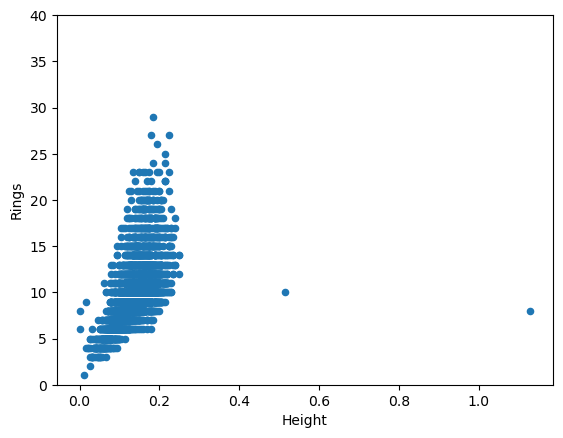

In [10]:
rings_height = pd.concat([data['Rings'], data['Height']], axis = 1)
rings_height.plot.scatter(x='Height', y='Rings', ylim=(0,40))

# Save and show the plot
plt.savefig('../eda/abalone_age/height_var_outliers.png')
plt.show()

It appears that there are two values in the data that do not follow the general trend.

The outlier problem found above will be handled later, after creating train/test split to avoid possible data leakage into test set.

## Correlation between variables

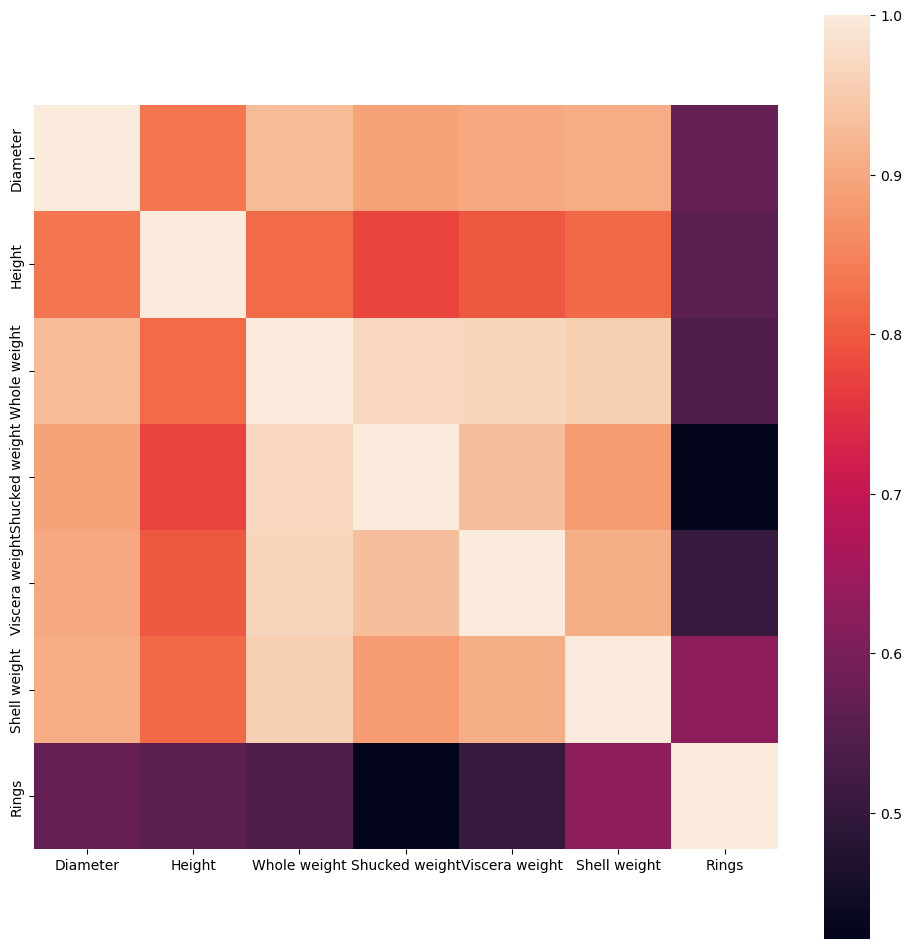

In [11]:
corr = data.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, vmax=1, square=True)

# Save and show the plot
plt.savefig('../eda/abalone_age/correlation_matrix.png')
plt.show()

The heatmap visualization indicates that the features exhibit strong correlations with each other, which may result in multicollinearity. Specifically, the feature "Whole weight" appears to have almost linear relationships with all other features except for "Rings." Meanwhile, "Length" is linearly correlated with "Diameter," and "Height" demonstrates the least correlation with other features when compared to the other features, excluding "Rings."

Furthermore, the "Rings" feature displays the highest correlation with "Shell Weight," followed by "Height," "Length," and "Diameter."

## Encoding categorical data

In [12]:
data = pd.get_dummies(data, columns=['Sex'])
data

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,1,0,0
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,0,0,1
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,0,0,1
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,1,0,0


## Split the data

In [13]:
data.to_csv('../data/abalone_age/abalone_cleaned.csv', index=False)

In [14]:
# Split the data into features and target
X = data.drop('Rings', axis=1)
y = data['Rings']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# # save the train set to a CSV file
# X_train.to_csv('../data/abalone_age/abalone_X_train.csv', index=False)
# y_train.to_csv('../data/abalone_age/abalone_y_train.csv', index=False)

# # save the test set to a CSV file
# X_test.to_csv('../data/abalone_age/abalone_X_test.csv', index=False)
# y_test.to_csv('../data/abalone_age/abalone_y_test.csv', index=False)

In [16]:
print("train_data_x:")
print(X_train.shape)

print("train_data_y:")
print(y_train.shape)

print("test_data_x:")
print(X_test.shape)

print("test_data_y:")
print(y_test.shape)

train_data_x:
(3341, 10)
train_data_y:
(3341,)
test_data_x:
(836, 10)
test_data_y:
(836,)


In [17]:
y_test

866      9
1483     8
599     16
1702     9
670     14
        ..
3093    11
1651     8
2897    10
3953     8
1830     7
Name: Rings, Length: 836, dtype: int64

## Handle the outliers and NULL values

We decided that we address the issue of outliers and NULL values by simply removing them from the dataset. That is because there are only 2 each, so information loss is negligible.

In [18]:
X_train[X_train.Height > 0.4]

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M
1417,0.705,0.565,0.515,2.210,1.1075,0.4865,0.5120,0,0,1
2051,0.455,0.355,1.130,0.594,0.3320,0.1160,0.1335,1,0,0


In [19]:
X_train = X_train[X_train.Height < 0.4]
y_train = y_train.drop([1417, 2051])

In [20]:
X_train = X_train[X_train.Height != 0.00]
y_train = y_train.drop([1257, 3996])

In [21]:
# save the train set to a CSV file
# X_train.to_csv('../data/abalone_age/abalone_X_train_preprocessed.csv', index=False)
# y_train.to_csv('../data/abalone_age/abalone_y_train_preprocessed.csv', index=False)

# Final processing and modelling

## Dummy Regressor (Baseline)

In [22]:
from sklearn.dummy import DummyRegressor

# Create a Dummy Regressor with strategy "mean"
dummy_regr = DummyRegressor(strategy="mean")

# Fit the Dummy Regressor on the training data
dummy_regr.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dummy_regr.predict(X_test)

In [23]:
from sklearn.dummy import DummyRegressor

# Create a Dummy Regressor with strategy "mean"
dummy_regr = DummyRegressor(strategy="mean")

# Fit the Dummy Regressor on the training data
dummy_regr.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dummy_regr.predict(X_test)

# Round the predicted values
y_pred_rounded = [int(round(val)) for val in y_pred]

# Compare the actual and predicted values
table = pd.DataFrame({'Actual_y_value':y_test, 'Predicted_y_value':y_pred_rounded})

accuracy_baseline = accuracy_score(y_test, y_pred_rounded)*100

print("Baseline accuracy is:")
print(accuracy_baseline)

mse_baseline = mean_squared_error(y_test, y_pred_rounded)

print("Baseline MSE is")
print(mse_baseline)

Baseline accuracy is:
16.626794258373206
Baseline MSE is
10.83732057416268


In [24]:
table

,Actual_y_value,Predicted_y_value
866,9,10
1483,8,10
599,16,10
1702,9,10
670,14,10
...,...,...
3093,11,10
1651,8,10
2897,10,10
3953,8,10


## Random Forest

In [25]:
pipeline_rfr = Pipeline([('regressor', RandomForestRegressor(random_state=42))])
pipeline_rfr_scaled = Pipeline([('scaler', StandardScaler()), ('regressor', RandomForestRegressor(random_state=42))])
# pipeline_rfr_pca = Pipeline([('pca', PCA()), ('regressor', RandomForestRegressor(random_state=42))])
# pipeline_rfr_scaled_pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('regressor', RandomForestRegressor(random_state=42))])


In [26]:
pipeline_rfr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'regressor', 'regressor__bootstrap', 'regressor__ccp_alpha', 'regressor__criterion', 'regressor__max_depth', 'regressor__max_features', 'regressor__max_leaf_nodes', 'regressor__max_samples', 'regressor__min_impurity_decrease', 'regressor__min_samples_leaf', 'regressor__min_samples_split', 'regressor__min_weight_fraction_leaf', 'regressor__n_estimators', 'regressor__n_jobs', 'regressor__oob_score', 'regressor__random_state', 'regressor__verbose', 'regressor__warm_start'])

In [27]:
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# number of features to consider at every split
max_features = ['auto', 'sqrt']
# max number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# min number of samples required to split a node
min_samples_split = [2, 5, 10]
# min number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree

# parameter grid
rfr_grid = {'regressor__n_estimators': n_estimators,
            'regressor__max_features': max_features,
            'regressor__max_depth': max_depth,
            'regressor__min_samples_split': min_samples_split,
            'regressor__min_samples_leaf': min_samples_leaf,
            'regressor__bootstrap': [True],
            'regressor__oob_score': [True]
           }

# rfr_grid_pca = {'regressor__n_estimators': n_estimators,
#             'regressor__max_features': max_features,
#             'regressor__max_depth': max_depth,
#             'regressor__min_samples_split': min_samples_split,
#             'regressor__min_samples_leaf': min_samples_leaf,
#             'regressor__bootstrap': bootstrap,
#             'pca__n_components': [2, 3, 4, 5],
#            }

### Base Random Forest

In [28]:
scoring = {'mse': make_scorer(mean_squared_error),
           'oob_score': 'r2'}

search = RandomizedSearchCV(pipeline_rfr, param_distributions=rfr_grid, verbose=3, cv=5, random_state=42, scoring=scoring, refit='mse')
search.fit(X_train, y_train)

# HOLDOUT
score = search.score(X_test, y_test)
y_pred=search.predict(X_test)

# Round the predicted values
y_pred_rounded = [int(round(val)) for val in y_pred]

# Compare the actual and predicted values
table = pd.DataFrame({'Actual_y_value':y_test, 'Predicted_y_value':y_pred_rounded})

accuracy_score_rf = accuracy_score(y_test, y_pred_rounded)*100

print("Accuracy is:")
print(accuracy_score_rf)

mse_score_rf = mean_squared_error(y_test, y_pred_rounded)

print("MSE  is:")
print(mse_score_rf)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END regressor__bootstrap=True, regressor__max_depth=50, regressor__max_features=sqrt, regressor__min_samples_leaf=2, regressor__min_samples_split=10, regressor__n_estimators=100, regressor__oob_score=True; mse: (test=4.023) oob_score: (test=0.542) total time=   0.2s
[CV 2/5] END regressor__bootstrap=True, regressor__max_depth=50, regressor__max_features=sqrt, regressor__min_samples_leaf=2, regressor__min_samples_split=10, regressor__n_estimators=100, regressor__oob_score=True; mse: (test=5.172) oob_score: (test=0.555) total time=   0.2s
[CV 3/5] END regressor__bootstrap=True, regressor__max_depth=50, regressor__max_features=sqrt, regressor__min_samples_leaf=2, regressor__min_samples_split=10, regressor__n_estimators=100, regressor__oob_score=True; mse: (test=4.891) oob_score: (test=0.577) total time=   0.2s
[CV 4/5] END regressor__bootstrap=True, regressor__max_depth=50, regressor__max_features=sqrt, regressor__min_s

In [29]:
# OOB + CV
mse_scores_df_rfr = pd.DataFrame(search.cv_results_)
mse_scores_df_rfr = mse_scores_df_rfr.sort_values(by=['rank_test_mse']).reset_index(drop='index').head(5)

oob_scores_df_rfr = pd.DataFrame(search.cv_results_)
oob_scores_df_rfr = oob_scores_df_rfr.sort_values(by=['rank_test_mse']).reset_index(drop='index').head(5)

scores_df_rfr = pd.concat([mse_scores_df_rfr, oob_scores_df_rfr], axis=1)
scores_df_rfr = scores_df_rfr[['params', 'mean_test_mse', 'rank_test_mse', 'mean_test_oob_score', 'rank_test_oob_score']]

scores_df_rfr


,params,params,mean_test_mse,mean_test_mse,rank_test_mse,rank_test_mse,mean_test_oob_score,mean_test_oob_score,rank_test_oob_score,rank_test_oob_score
0,"{'regressor__oob_score': True, 'regressor__n_e...","{'regressor__oob_score': True, 'regressor__n_e...",4.601899,4.601899,1,1,0.548873,0.548873,9,9
1,"{'regressor__oob_score': True, 'regressor__n_e...","{'regressor__oob_score': True, 'regressor__n_e...",4.601569,4.601569,2,2,0.548806,0.548806,10,10
2,"{'regressor__oob_score': True, 'regressor__n_e...","{'regressor__oob_score': True, 'regressor__n_e...",4.576336,4.576336,3,3,0.551530,0.551530,8,8
3,"{'regressor__oob_score': True, 'regressor__n_e...","{'regressor__oob_score': True, 'regressor__n_e...",4.569530,4.569530,4,4,0.552209,0.552209,7,7
4,"{'regressor__oob_score': True, 'regressor__n_e...","{'regressor__oob_score': True, 'regressor__n_e...",4.542452,4.542452,5,5,0.554744,0.554744,6,6


In [30]:
# CV 
scores_df_rfr = pd.DataFrame(search.cv_results_)
scores_df_rfr = scores_df_rfr.sort_values(by=['rank_test_mse']).reset_index(drop='index')

scores_df_rfr.head(10)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__oob_score,param_regressor__n_estimators,param_regressor__min_samples_split,param_regressor__min_samples_leaf,param_regressor__max_features,param_regressor__max_depth,...,std_test_mse,rank_test_mse,split0_test_oob_score,split1_test_oob_score,split2_test_oob_score,split3_test_oob_score,split4_test_oob_score,mean_test_oob_score,std_test_oob_score,rank_test_oob_score
0,6.985600,0.251506,0.118882,4.057756e-03,True,900,5,1,auto,100,...,0.410378,1,0.523143,0.558714,0.571927,0.562535,0.528043,0.548873,0.019549,9
1,4.431555,0.020085,0.077200,7.947941e-04,True,600,5,1,auto,70,...,0.401902,2,0.520767,0.560702,0.571707,0.562325,0.528527,0.548806,0.020229,10
2,2.203108,0.041654,0.039095,1.465675e-03,True,300,5,2,auto,90,...,0.419208,3,0.523666,0.561456,0.573246,0.562908,0.536374,0.551530,0.018470,8
3,3.605764,0.049069,0.064428,1.849484e-03,True,500,2,2,auto,80,...,0.418572,4,0.527095,0.561905,0.573762,0.563597,0.534685,0.552209,0.018034,7
4,0.641272,0.001257,0.012971,1.242195e-05,True,100,10,2,auto,70,...,0.408857,5,0.529215,0.566116,0.572977,0.571250,0.534164,0.554744,0.019024,6
5,2.578306,0.036374,0.093748,3.989221e-03,True,700,5,1,sqrt,30,...,0.453812,6,0.531909,0.558090,0.570982,0.575756,0.539774,0.555302,0.017090,5
6,0.316952,0.008330,0.013564,7.981063e-04,True,100,2,4,sqrt,20,...,0.489650,7,0.542022,0.555195,0.567746,0.577751,0.540741,0.556691,0.014405,4
7,1.787021,0.021142,0.069015,7.468754e-04,True,600,2,4,sqrt,None,...,0.501939,8,0.542033,0.552999,0.568629,0.577296,0.544497,0.557091,0.013736,3
8,2.843832,0.066914,0.104327,1.489798e-03,True,900,2,4,sqrt,70,...,0.502527,9,0.543730,0.553310,0.568494,0.577389,0.543602,0.557305,0.013539,2
9,0.297428,0.003096,0.012965,1.907349e-07,True,100,10,2,sqrt,50,...,0.473578,10,0.542057,0.555291,0.577080,0.571359,0.542216,0.557600,0.014508,1


In [31]:
top_n = 10
runtimes = scores_df_rfr[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']].iloc[:top_n]
runtimes['rank'] = range(1, top_n + 1)
runtimes = runtimes.set_index('rank')
print(runtimes)


      mean_fit_time  std_fit_time  mean_score_time  std_score_time
rank                                                              
1          6.985600      0.251506         0.118882    4.057756e-03
2          4.431555      0.020085         0.077200    7.947941e-04
3          2.203108      0.041654         0.039095    1.465675e-03
4          3.605764      0.049069         0.064428    1.849484e-03
5          0.641272      0.001257         0.012971    1.242195e-05
6          2.578306      0.036374         0.093748    3.989221e-03
7          0.316952      0.008330         0.013564    7.981063e-04
8          1.787021      0.021142         0.069015    7.468754e-04
9          2.843832      0.066914         0.104327    1.489798e-03
10         0.297428      0.003096         0.012965    1.907349e-07


In [32]:
# Get the best hyperparameter set and the top 10 hyperparameter sets
top_params = search.cv_results_['params'][:10]

# Train a new model for each of the top 10 hyperparameter sets
histories = []
for params in top_params:
    model = Pipeline(steps=[('regressor', RandomForestRegressor(n_estimators=params['regressor__n_estimators'],
                                                                 max_features=params['regressor__max_features'],
                                                                 max_depth=params['regressor__max_depth'],
                                                                 min_samples_split=params['regressor__min_samples_split'],
                                                                 min_samples_leaf=params['regressor__min_samples_leaf'],
                                                                 bootstrap=params['regressor__bootstrap'],
                                                                 oob_score=params['regressor__oob_score']))])
    model.fit(X_train, y_train)
    histories.append(model)

    
# Evaluate each model on the test set
for history in histories:
    print(history)
    # Get the model's predictions on the test data
    y_pred = history.predict(X_test)
    
    # Round the predicted values
    y_pred_rounded = [int(np.round(val)) for val in y_pred]
    
    # Calculate the accuracy score
    acc_score = accuracy_score(y_test, y_pred_rounded)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred_rounded)
    
    # Print the scores for this model
    print("Accuracy score: ", acc_score)
    print("Mean squared error: ", mse)


Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=50, max_features='sqrt',
                                       min_samples_leaf=2, min_samples_split=10,
                                       oob_score=True))])
Accuracy score:  0.22129186602870812
Mean squared error:  4.883971291866029
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=80, min_samples_leaf=2,
                                       n_estimators=500, oob_score=True))])
Accuracy score:  0.2332535885167464
Mean squared error:  4.997607655502392
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=70, min_samples_leaf=2,
                                       min_samples_split=10, oob_score=True))])
Accuracy score:  0.24043062200956938
Mean squared error:  4.95933014354067
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=70, min_samples_split=5,
                                       n_estimators=600, oob_scor

### Data scaling

In [33]:
scoring = {'mse': make_scorer(mean_squared_error),
           'oob_score': 'r2'}

search = RandomizedSearchCV(pipeline_rfr_scaled, param_distributions=rfr_grid, verbose=3, cv=5, random_state=42, scoring=scoring, refit='mse')
search.fit(X_train, y_train)

# HOLDOUT top1
score = search.score(X_test, y_test)
y_pred=search.predict(X_test)

# Round the predicted values
y_pred_rounded = [int(round(val)) for val in y_pred]

# Compare the actual and predicted values
table = pd.DataFrame({'Actual_y_value':y_test, 'Predicted_y_value':y_pred_rounded})

accuracy_score_rf_scaled = accuracy_score(y_test, y_pred_rounded)*100

print("Accuracy is:")
print(accuracy_score_rf_scaled)

mse_score_rf_scaled = mean_squared_error(y_test, y_pred_rounded)

print("MSE  is:")
print(mse_score_rf_scaled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END regressor__bootstrap=True, regressor__max_depth=50, regressor__max_features=sqrt, regressor__min_samples_leaf=2, regressor__min_samples_split=10, regressor__n_estimators=100, regressor__oob_score=True; mse: (test=4.023) oob_score: (test=0.542) total time=   0.3s
[CV 2/5] END regressor__bootstrap=True, regressor__max_depth=50, regressor__max_features=sqrt, regressor__min_samples_leaf=2, regressor__min_samples_split=10, regressor__n_estimators=100, regressor__oob_score=True; mse: (test=5.174) oob_score: (test=0.555) total time=   0.3s
[CV 3/5] END regressor__bootstrap=True, regressor__max_depth=50, regressor__max_features=sqrt, regressor__min_samples_leaf=2, regressor__min_samples_split=10, regressor__n_estimators=100, regressor__oob_score=True; mse: (test=4.889) oob_score: (test=0.577) total time=   0.3s
[CV 4/5] END regressor__bootstrap=True, regressor__max_depth=50, regressor__max_features=sqrt, regressor__min_s

In [34]:
# OOB + CV
mse_scores_df_rfr_scaled = pd.DataFrame(search.cv_results_)
mse_scores_df_rfr_scaled = mse_scores_df_rfr_scaled.sort_values(by=['rank_test_mse']).reset_index(drop='index').head(5)

oob_scores_df_rfr_scaled = pd.DataFrame(search.cv_results_)
oob_scores_df_rfr_scaled = oob_scores_df_rfr_scaled.sort_values(by=['rank_test_mse']).reset_index(drop='index').head(5)

scores_df_rfr_scaled = pd.concat([mse_scores_df_rfr_scaled, oob_scores_df_rfr_scaled], axis=1)
scores_df_rfr_scaled = scores_df_rfr_scaled[['params', 'mean_test_mse', 'rank_test_mse', 'mean_test_oob_score', 'rank_test_oob_score']]

scores_df_rfr_scaled


,params,params,mean_test_mse,mean_test_mse,rank_test_mse,rank_test_mse,mean_test_oob_score,mean_test_oob_score,rank_test_oob_score,rank_test_oob_score
0,"{'regressor__oob_score': True, 'regressor__n_e...","{'regressor__oob_score': True, 'regressor__n_e...",4.604524,4.604524,1,1,0.548427,0.548427,10,10
1,"{'regressor__oob_score': True, 'regressor__n_e...","{'regressor__oob_score': True, 'regressor__n_e...",4.604117,4.604117,2,2,0.548558,0.548558,9,9
2,"{'regressor__oob_score': True, 'regressor__n_e...","{'regressor__oob_score': True, 'regressor__n_e...",4.579305,4.579305,3,3,0.551187,0.551187,8,8
3,"{'regressor__oob_score': True, 'regressor__n_e...","{'regressor__oob_score': True, 'regressor__n_e...",4.571794,4.571794,4,4,0.551886,0.551886,7,7
4,"{'regressor__oob_score': True, 'regressor__n_e...","{'regressor__oob_score': True, 'regressor__n_e...",4.544529,4.544529,5,5,0.554998,0.554998,5,5


In [35]:
# CV 
scores_df_rfr_scaled = pd.DataFrame(search.cv_results_)
scores_df_rfr_scaled = scores_df_rfr_scaled.sort_values(by=['rank_test_mse']).reset_index(drop='index')

scores_df_rfr_scaled.head(10)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__oob_score,param_regressor__n_estimators,param_regressor__min_samples_split,param_regressor__min_samples_leaf,param_regressor__max_features,param_regressor__max_depth,...,std_test_mse,rank_test_mse,split0_test_oob_score,split1_test_oob_score,split2_test_oob_score,split3_test_oob_score,split4_test_oob_score,mean_test_oob_score,std_test_oob_score,rank_test_oob_score
0,5.416316,0.149491,0.094147,0.003547,True,600,5,1,auto,70,...,0.395089,1,0.519969,0.561034,0.572396,0.561671,0.527065,0.548427,0.020857,10
1,8.052664,0.527134,0.147806,0.023308,True,900,5,1,auto,100,...,0.402947,2,0.522248,0.559173,0.572749,0.561966,0.526657,0.548558,0.020246,9
2,2.820657,0.624401,0.050264,0.009172,True,300,5,2,auto,90,...,0.414946,3,0.523523,0.561647,0.573562,0.562173,0.535026,0.551187,0.018747,8
3,4.263400,0.054299,0.075603,0.000748,True,500,2,2,auto,80,...,0.410845,4,0.526410,0.562336,0.574602,0.563098,0.532985,0.551886,0.018747,7
4,2.875510,0.254229,0.104727,0.010727,True,700,5,1,sqrt,30,...,0.451771,5,0.531392,0.557846,0.571358,0.575114,0.539282,0.554998,0.017232,5
5,0.775320,0.010972,0.015358,0.000489,True,100,10,2,auto,70,...,0.405951,6,0.529084,0.566551,0.573131,0.570940,0.533646,0.554670,0.019201,6
6,0.383774,0.043633,0.015757,0.001164,True,100,2,4,sqrt,20,...,0.489207,7,0.542251,0.555634,0.567456,0.577406,0.540683,0.556686,0.014219,4
7,1.928230,0.050784,0.073743,0.008108,True,600,2,4,sqrt,None,...,0.500244,8,0.541870,0.553256,0.568647,0.577035,0.544234,0.557008,0.013733,3
8,3.210007,0.059841,0.115093,0.003869,True,900,2,4,sqrt,70,...,0.501228,9,0.543511,0.553476,0.568499,0.577120,0.543431,0.557207,0.013530,2
9,0.402916,0.015987,0.016756,0.001829,True,100,10,2,sqrt,50,...,0.473949,10,0.542107,0.555143,0.577187,0.570857,0.542173,0.557493,0.014446,1


In [36]:
top_n = 10
runtimes = scores_df_rfr_scaled[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']].iloc[:top_n]
runtimes['rank'] = range(1, top_n + 1)
runtimes = runtimes.set_index('rank')
print(runtimes)


      mean_fit_time  std_fit_time  mean_score_time  std_score_time
rank                                                              
1          5.416316      0.149491         0.094147        0.003547
2          8.052664      0.527134         0.147806        0.023308
3          2.820657      0.624401         0.050264        0.009172
4          4.263400      0.054299         0.075603        0.000748
5          2.875510      0.254229         0.104727        0.010727
6          0.775320      0.010972         0.015358        0.000489
7          0.383774      0.043633         0.015757        0.001164
8          1.928230      0.050784         0.073743        0.008108
9          3.210007      0.059841         0.115093        0.003869
10         0.402916      0.015987         0.016756        0.001829


In [37]:
# Get the best hyperparameter set and the top 10 hyperparameter sets
top_params = search.cv_results_['params'][:10]

# Train a new model for each of the top 10 hyperparameter sets
histories = []
for params in top_params:
    model = Pipeline(steps=[('scaler', StandardScaler()), ('regressor', RandomForestRegressor(n_estimators=params['regressor__n_estimators'],
                                                                 max_features=params['regressor__max_features'],
                                                                 max_depth=params['regressor__max_depth'],
                                                                 min_samples_split=params['regressor__min_samples_split'],
                                                                 min_samples_leaf=params['regressor__min_samples_leaf'],
                                                                 bootstrap=params['regressor__bootstrap'],
                                                                 oob_score=params['regressor__oob_score']))])
    model.fit(X_train, y_train)
    histories.append(model)

    
# Evaluate each model on the test set
for history in histories:
    # Get the model's predictions on the test data
    print(history)
    y_pred = history.predict(X_test)
    
    # Round the predicted values
    y_pred_rounded = [int(np.round(val)) for val in y_pred]
    
    # Calculate the accuracy score
    acc_score = accuracy_score(y_test, y_pred_rounded)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred_rounded)
    
    # Print the scores for this model
    print("Accuracy score: ", acc_score)
    print("Mean squared error: ", mse)


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(max_depth=50, max_features='sqrt',
                                       min_samples_leaf=2, min_samples_split=10,
                                       oob_score=True))])
Accuracy score:  0.21650717703349281
Mean squared error:  4.972488038277512
Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(max_depth=80, min_samples_leaf=2,
                                       n_estimators=500, oob_score=True))])
Accuracy score:  0.22966507177033493
Mean squared error:  5.019138755980861
Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(max_depth=70, min_samples_leaf=2,
                                       min_samples_split=10, oob_score=True))])
Accuracy score:  0.2452153110047847
Mean squared error:  4.990430622009569
Pipeline(steps=[('scaler', Sta

### PCA

In [38]:
# # 5-fold cv in default

# search = RandomizedSearchCV(pipeline_rfr_pca, param_distributions=rfr_grid, verbose=3, cv=5, random_state=42, scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error')
# search.fit(X_train, y_train)

# score = search.score(X_test, y_test)
# y_pred=search.predict(X_test)

# # Round the predicted values
# y_pred_rounded = [int(round(val)) for val in y_pred]

# # Compare the actual and predicted values
# table = pd.DataFrame({'Actual_y_value':y_test, 'Predicted_y_value':y_pred_rounded})

# accuracy_score_rf_pca = accuracy_score(y_test, y_pred_rounded)*100

# print("Accuracy is:")
# print(accuracy_score_rf_pca)

# mse_score_rf_pca = mean_squared_error(y_test, y_pred_rounded)

# print("MSE  is:")
# print(mse_score_rf_pca)

In [39]:
# scores_df_rfr_pca = pd.DataFrame(search.cv_results_)
# scores_df_rfr_pca = scores_df_rfr_pca.sort_values(by=['rank_test_neg_mean_squared_error']).reset_index(drop='index')
# scores_df_rfr_pca.head(5)

### Scaling + PCA

In [40]:
# # 5-fold cv in default

# search = RandomizedSearchCV(pipeline_rfr_scaled_pca, param_distributions=rfr_grid, verbose=3, cv=5, random_state=42, scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error')
# search.fit(X_train, y_train)

# score = search.score(X_test, y_test)
# y_pred=search.predict(X_test)

# # Round the predicted values
# y_pred_rounded = [int(round(val)) for val in y_pred]

# # Compare the actual and predicted values
# table = pd.DataFrame({'Actual_y_value':y_test, 'Predicted_y_value':y_pred_rounded})

# accuracy_score_rf_scaled_pca = accuracy_score(y_test, y_pred_rounded)*100

# print("Accuracy is:")
# print(accuracy_score_rf_scaled_pca)

# mse_score_rf_scaled_pca = mean_squared_error(y_test, y_pred_rounded)

# print("MSE  is:")
# print(mse_score_rf_scaled_pca)

In [41]:
# scores_df_rfr_scaled_pca = pd.DataFrame(search.cv_results_)
# scores_df_rfr_scaled_pca = scores_df_rfr_scaled_pca.sort_values(by=['rank_test_neg_mean_squared_error']).reset_index(drop='index')
# scores_df_rfr_scaled_pca.head(5)

In [42]:
# CV VALUES

mean_test_mse_rfr = abs(scores_df_rfr.head(1)['mean_test_mse'].values[0])
mean_test_mse_rfr_scaled = abs(scores_df_rfr_scaled.head(1)['mean_test_mse'].values[0])
# mean_test_mse_rfr_pca = abs(scores_df_rfr_pca.head(1)['mean_test_neg_mean_squared_error'].values[0])
# mean_test_mse_rfr_scaled_pca = abs(scores_df_rfr_scaled_pca.head(1)['mean_test_neg_mean_squared_error'].values[0])


# # HOLDOUT VALUES
# accuracy_score_rf
# accuracy_score_rf_scaled
# accuracy_score_rf_pca
# accuracy_score_rf_scaled_pca

# mse_score_rf
# mse_score_rf_scaled
# mse_score_rf_pca
# mse_score_rf_scaled_pca



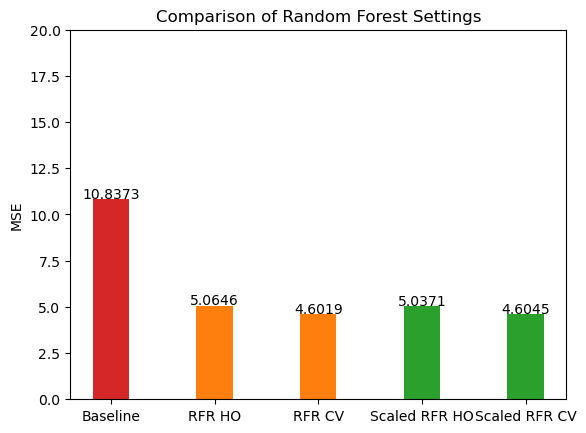

In [43]:
import numpy as np
import matplotlib.pyplot as plt


# Set labels and scores for each regressor
labels = ['Baseline', 'RFR HO', 'RFR CV', 'Scaled RFR HO', 'Scaled RFR CV']
mse_scores = [mse_baseline, mse_score_rf, mean_test_mse_rfr, mse_score_rf_scaled, mean_test_mse_rfr_scaled]


# Create bar chart
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x, mse_scores, width, label='MSE', color=['tab:red', 'tab:orange', 'tab:orange', 'tab:green', 'tab:green'])

# Add exact values of each bar to the top of the bars
for i, v in enumerate(mse_scores):
    ax.text(i, v + 0.05, str(round(v, 4)), ha='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('Comparison of Random Forest Settings')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Adjust y-axis scale
ax.set_ylim([0, 20])

# Save and show the plot
plt.savefig('../results/abalone_age/rfr_comparison_mse.png')
plt.show()


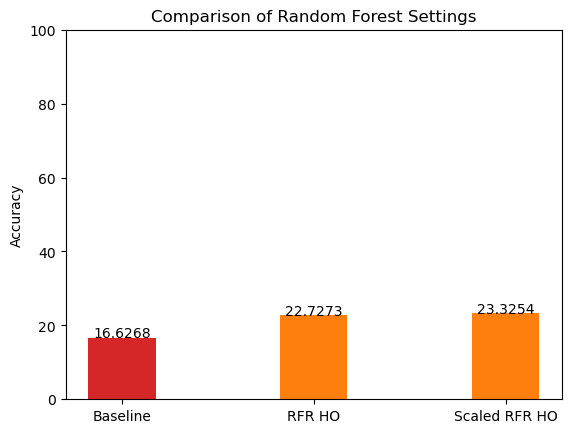

In [44]:
import numpy as np
import matplotlib.pyplot as plt


# Set labels and scores for each regressor
labels = ['Baseline', 'RFR HO', 'Scaled RFR HO']
accuracy_scores = [accuracy_baseline, accuracy_score_rf, accuracy_score_rf_scaled]


# Create bar chart
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x, accuracy_scores, width, label='Accuracy', color=['tab:red', 'tab:orange', 'tab:orange'])

# Add exact values of each bar to the top of the bars
for i, v in enumerate(accuracy_scores):
    ax.text(i, v + 0.05, str(round(v, 4)), ha='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Random Forest Settings')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Adjust y-axis scale
ax.set_ylim([0, 100])

# Save and show the plot
plt.savefig('../results/abalone_age/rfr_comparison_acc.png')
plt.show()


## KNN

In [45]:
pipeline_knn = Pipeline([('regressor', KNeighborsRegressor())])
pipeline_knn_scaled = Pipeline([('scaler', StandardScaler()), ('regressor', KNeighborsRegressor())])
# pipeline_knn_pca = Pipeline([('pca', PCA()), ('regressor', KNeighborsRegressor())])
# pipeline_knn_scaled_pca = Pipeline([('pca', PCA()), ('scaler', StandardScaler()), ('regressor', KNeighborsRegressor())])


In [46]:
pipeline_knn.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'regressor', 'regressor__algorithm', 'regressor__leaf_size', 'regressor__metric', 'regressor__metric_params', 'regressor__n_jobs', 'regressor__n_neighbors', 'regressor__p', 'regressor__weights'])

In [47]:
k_range = list(range(1, 31))

# parameter grid for KNeighborsRegressor
knn_grid = {'regressor__n_neighbors': k_range,
            'regressor__weights': ['uniform', 'distance'],
            'regressor__metric': ['euclidean', 'manhattan'],
            'regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
           }

# knn_grid_pca = {'regressor__n_neighbors': k_range,
#                 'regressor__weights': ['uniform', 'distance'],
#                 'regressor__metric': ['euclidean', 'manhattan'],
#                 'regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#                 'pca__n_components': [2, 5, 8]
#                }


### Base KNN

In [48]:

search = RandomizedSearchCV(pipeline_knn, param_distributions=knn_grid, verbose=3, cv=5, random_state=42, scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error')
search.fit(X_train, y_train)

score = search.score(X_test, y_test)

# Get predicted values from the best model
y_pred = search.predict(X_test)

# Round the predicted values
y_pred_rounded = [int(round(val)) for val in y_pred]

# Compare the actual and predicted values
table = pd.DataFrame({'Actual_y_value':y_test, 'Predicted_y_value':y_pred_rounded})

accuracy_score_knn = accuracy_score(y_test, y_pred_rounded)*100

print("Accuracy is:")
print(accuracy_score_knn)

mse_score_knn = mean_squared_error(y_test, y_pred_rounded)

print("MSE  is:")
print(mse_score_knn)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END regressor__algorithm=auto, regressor__metric=manhattan, regressor__n_neighbors=7, regressor__weights=distance; neg_mean_squared_error: (test=-4.236) total time=   0.0s
[CV 2/5] END regressor__algorithm=auto, regressor__metric=manhattan, regressor__n_neighbors=7, regressor__weights=distance; neg_mean_squared_error: (test=-5.937) total time=   0.0s
[CV 3/5] END regressor__algorithm=auto, regressor__metric=manhattan, regressor__n_neighbors=7, regressor__weights=distance; neg_mean_squared_error: (test=-5.588) total time=   0.0s
[CV 4/5] END regressor__algorithm=auto, regressor__metric=manhattan, regressor__n_neighbors=7, regressor__weights=distance; neg_mean_squared_error: (test=-4.691) total time=   0.0s
[CV 5/5] END regressor__algorithm=auto, regressor__metric=manhattan, regressor__n_neighbors=7, regressor__weights=distance; neg_mean_squared_error: (test=-4.344) total time=   0.0s
[CV 1/5] END regressor__algorithm=

In [49]:
table

,Actual_y_value,Predicted_y_value
866,9,12
1483,8,9
599,16,13
1702,9,11
670,14,12
...,...,...
3093,11,11
1651,8,9
2897,10,9
3953,8,8


In [50]:
scores_df_knn = pd.DataFrame(search.cv_results_)
scores_df_knn = scores_df_knn.sort_values(by=['rank_test_neg_mean_squared_error']).reset_index(drop='index')
#top_score_knn_mse = abs(scores_df_knn_mse.loc[0, 'mean_test_neg_mean_squared_error'])
#top_score_knn_acc = abs(scores_df_knn_mse.loc[0, 'mean_test_accuracy'])

scores_df_knn.head(10)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__weights,param_regressor__n_neighbors,param_regressor__metric,param_regressor__algorithm,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error
0,0.006582,4.883830e-04,0.010173,0.000746,distance,19,euclidean,kd_tree,"{'regressor__weights': 'distance', 'regressor_...",-4.026484,-5.690341,-5.473469,-4.587246,-4.089755,-4.773459,0.691489,1
1,0.001596,4.884225e-04,0.032912,0.000630,distance,20,euclidean,brute,"{'regressor__weights': 'distance', 'regressor_...",-4.051454,-5.693505,-5.467893,-4.600299,-4.115831,-4.785796,0.679957,2
2,0.001197,3.984452e-04,0.043085,0.003179,uniform,12,manhattan,brute,"{'regressor__weights': 'uniform', 'regressor__...",-4.087367,-5.820546,-5.492764,-4.614120,-4.056472,-4.814254,0.723278,3
3,0.006383,4.882467e-04,0.009176,0.000746,uniform,15,euclidean,kd_tree,"{'regressor__weights': 'uniform', 'regressor__...",-4.116341,-5.720393,-5.529842,-4.644325,-4.133147,-4.828809,0.679994,4
4,0.006582,4.887340e-04,0.008777,0.000746,distance,9,manhattan,auto,"{'regressor__weights': 'distance', 'regressor_...",-4.127718,-5.774663,-5.450211,-4.670856,-4.138082,-4.832306,0.674433,5
5,0.001995,9.536743e-08,0.032712,0.000746,uniform,18,euclidean,brute,"{'regressor__weights': 'uniform', 'regressor__...",-4.069237,-5.802261,-5.549679,-4.619847,-4.122231,-4.832651,0.719313,6
6,0.002194,3.987076e-04,0.031316,0.000488,distance,8,euclidean,brute,"{'regressor__weights': 'distance', 'regressor_...",-4.194494,-5.641928,-5.591755,-4.670613,-4.237608,-4.867280,0.634468,7
7,0.004388,4.885194e-04,0.011370,0.000798,uniform,27,euclidean,ball_tree,"{'regressor__weights': 'uniform', 'regressor__...",-4.200396,-5.829261,-5.630872,-4.821474,-4.285351,-4.953471,0.671835,8
8,0.001995,6.313544e-04,0.033710,0.000746,uniform,28,euclidean,brute,"{'regressor__weights': 'uniform', 'regressor__...",-4.203335,-5.847021,-5.632902,-4.827313,-4.270246,-4.956163,0.679034,9
9,0.007180,1.162262e-03,0.007979,0.001892,distance,7,manhattan,auto,"{'regressor__weights': 'distance', 'regressor_...",-4.235850,-5.937102,-5.588181,-4.690549,-4.344393,-4.959215,0.681954,10


In [51]:
top_n = 10
runtimes = scores_df_knn[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']].iloc[:top_n]
runtimes['rank'] = range(1, top_n + 1)
runtimes = runtimes.set_index('rank')
print(runtimes)


      mean_fit_time  std_fit_time  mean_score_time  std_score_time
rank                                                              
1          0.006582  4.883830e-04         0.010173        0.000746
2          0.001596  4.884225e-04         0.032912        0.000630
3          0.001197  3.984452e-04         0.043085        0.003179
4          0.006383  4.882467e-04         0.009176        0.000746
5          0.006582  4.887340e-04         0.008777        0.000746
6          0.001995  9.536743e-08         0.032712        0.000746
7          0.002194  3.987076e-04         0.031316        0.000488
8          0.004388  4.885194e-04         0.011370        0.000798
9          0.001995  6.313544e-04         0.033710        0.000746
10         0.007180  1.162262e-03         0.007979        0.001892


In [52]:
# Get the best hyperparameter set and the top 10 hyperparameter sets
top_params = search.cv_results_['params'][:10]

# Train a new model for each of the top 10 hyperparameter sets
histories = []
for params in top_params:
    model = Pipeline(steps=[('regressor', KNeighborsRegressor(n_neighbors=params['regressor__n_neighbors'],
                                                              weights=params['regressor__weights'],
                                                              metric=params['regressor__metric'],
                                                              algorithm=params['regressor__algorithm']))])
    model.fit(X_train, y_train)
    histories.append(model)

    
# Evaluate each model on the test set
for history in histories:
    print(history)
    # Get the model's predictions on the test data
    y_pred = history.predict(X_test)
    
    # Round the predicted values
    y_pred_rounded = [int(np.round(val)) for val in y_pred]
    
    # Calculate the accuracy score
    acc_score = accuracy_score(y_test, y_pred_rounded)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred_rounded)
    
    # Print the scores for this model
    print("Accuracy score: ", acc_score)
    print("Mean squared error: ", mse)


Pipeline(steps=[('regressor',
                 KNeighborsRegressor(metric='manhattan', n_neighbors=7,
                                     weights='distance'))])
Accuracy score:  0.2631578947368421
Mean squared error:  5.186602870813397
Pipeline(steps=[('regressor',
                 KNeighborsRegressor(algorithm='brute', metric='euclidean',
                                     n_neighbors=28))])
Accuracy score:  0.2583732057416268
Mean squared error:  4.901913875598086
Pipeline(steps=[('regressor',
                 KNeighborsRegressor(algorithm='brute', metric='euclidean',
                                     n_neighbors=18))])
Accuracy score:  0.26913875598086123
Mean squared error:  5.01555023923445
Pipeline(steps=[('regressor',
                 KNeighborsRegressor(algorithm='kd_tree', metric='euclidean',
                                     n_neighbors=19, weights='distance'))])
Accuracy score:  0.26913875598086123
Mean squared error:  4.889952153110048
Pipeline(steps=[('regressor',

### Scaling

In [53]:
# search = RandomizedSearchCV(pipeline_knn_scaled, param_distributions=knn_grid, verbose=3, cv=2, random_state=42, scoring=['neg_mean_squared_error','accuracy'], refit='neg_mean_squared_error')
# search.fit(X_train, y_train)

# score = search.score(X_test, y_test)
# y_pred=search.predict(X_test)

In [54]:
search = RandomizedSearchCV(pipeline_knn_scaled, param_distributions=knn_grid, verbose=3, cv=5, random_state=42, scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error')
search.fit(X_train, y_train)

score = search.score(X_test, y_test)

# Get predicted values from the model
y_pred = search.predict(X_test)

# Round the predicted values
y_pred_rounded = [int(round(val)) for val in y_pred]

# Compare the actual and predicted values
table = pd.DataFrame({'Actual_y_value':y_test, 'Predicted_y_value':y_pred_rounded})

accuracy_score_knn_scaled = accuracy_score(y_test, y_pred_rounded)*100

print("Accuracy is:")
print(accuracy_score_knn_scaled)

mse_score_knn_scaled = mean_squared_error(y_test, y_pred_rounded)

print("MSE  is:")
print(mse_score_knn_scaled)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END regressor__algorithm=auto, regressor__metric=manhattan, regressor__n_neighbors=7, regressor__weights=distance; neg_mean_squared_error: (test=-4.218) total time=   0.0s
[CV 2/5] END regressor__algorithm=auto, regressor__metric=manhattan, regressor__n_neighbors=7, regressor__weights=distance; neg_mean_squared_error: (test=-6.018) total time=   0.0s
[CV 3/5] END regressor__algorithm=auto, regressor__metric=manhattan, regressor__n_neighbors=7, regressor__weights=distance; neg_mean_squared_error: (test=-5.561) total time=   0.0s
[CV 4/5] END regressor__algorithm=auto, regressor__metric=manhattan, regressor__n_neighbors=7, regressor__weights=distance; neg_mean_squared_error: (test=-5.029) total time=   0.0s
[CV 5/5] END regressor__algorithm=auto, regressor__metric=manhattan, regressor__n_neighbors=7, regressor__weights=distance; neg_mean_squared_error: (test=-4.465) total time=   0.0s
[CV 1/5] END regressor__algorithm=

In [55]:
scores_df_knn_scaled = pd.DataFrame(search.cv_results_)
scores_df_knn_scaled = scores_df_knn_scaled.sort_values(by=['rank_test_neg_mean_squared_error']).reset_index(drop='index')

scores_df_knn_scaled.head(10)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__weights,param_regressor__n_neighbors,param_regressor__metric,param_regressor__algorithm,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error
0,0.007978,0.000631,0.012766,0.000399,distance,19,euclidean,kd_tree,"{'regressor__weights': 'distance', 'regressor_...",-4.172328,-5.867640,-5.501597,-4.862942,-4.312287,-4.943359,0.658047,1
1,0.003191,0.000399,0.032114,0.000746,distance,20,euclidean,brute,"{'regressor__weights': 'distance', 'regressor_...",-4.169267,-5.865915,-5.513605,-4.887582,-4.338605,-4.954995,0.654778,2
2,0.007380,0.001017,0.011569,0.000798,uniform,15,euclidean,kd_tree,"{'regressor__weights': 'uniform', 'regressor__...",-4.206114,-5.955123,-5.475482,-4.889655,-4.350125,-4.975300,0.663334,3
3,0.003590,0.000488,0.042686,0.003752,uniform,12,manhattan,brute,"{'regressor__weights': 'uniform', 'regressor__...",-4.103241,-5.941596,-5.540719,-4.981530,-4.385942,-4.990606,0.687040,4
4,0.003590,0.000489,0.031316,0.000798,uniform,18,euclidean,brute,"{'regressor__weights': 'uniform', 'regressor__...",-4.193400,-5.917092,-5.526107,-4.939651,-4.382110,-4.991672,0.656282,5
5,0.007979,0.000630,0.012168,0.001163,distance,9,manhattan,auto,"{'regressor__weights': 'distance', 'regressor_...",-4.115167,-5.983003,-5.540768,-4.968834,-4.407470,-5.003048,0.691907,6
6,0.003191,0.000399,0.031716,0.000745,distance,8,euclidean,brute,"{'regressor__weights': 'distance', 'regressor_...",-4.386482,-6.116486,-5.560905,-4.812221,-4.324920,-5.040203,0.695769,7
7,0.005585,0.000488,0.019548,0.002053,uniform,27,euclidean,ball_tree,"{'regressor__weights': 'uniform', 'regressor__...",-4.260103,-5.940697,-5.657895,-5.006472,-4.425287,-5.058091,0.660098,8
8,0.006781,0.000746,0.008777,0.000399,distance,7,manhattan,auto,"{'regressor__weights': 'distance', 'regressor_...",-4.218230,-6.017801,-5.560957,-5.029384,-4.464830,-5.058240,0.668142,9
9,0.003790,0.000978,0.036103,0.006892,uniform,28,euclidean,brute,"{'regressor__weights': 'uniform', 'regressor__...",-4.249649,-5.947645,-5.662141,-5.023816,-4.428009,-5.062252,0.664508,10


In [56]:
top_n = 10
runtimes = scores_df_knn_scaled[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']].iloc[:top_n]
runtimes['rank'] = range(1, top_n + 1)
runtimes = runtimes.set_index('rank')
print(runtimes)


      mean_fit_time  std_fit_time  mean_score_time  std_score_time
rank                                                              
1          0.007978      0.000631         0.012766        0.000399
2          0.003191      0.000399         0.032114        0.000746
3          0.007380      0.001017         0.011569        0.000798
4          0.003590      0.000488         0.042686        0.003752
5          0.003590      0.000489         0.031316        0.000798
6          0.007979      0.000630         0.012168        0.001163
7          0.003191      0.000399         0.031716        0.000745
8          0.005585      0.000488         0.019548        0.002053
9          0.006781      0.000746         0.008777        0.000399
10         0.003790      0.000978         0.036103        0.006892


In [57]:
# Get the best hyperparameter set and the top 10 hyperparameter sets
top_params = search.cv_results_['params'][:10]

# Train a new model for each of the top 10 hyperparameter sets
histories = []
for params in top_params:
    model = Pipeline(steps=[('scaler', StandardScaler()), 
                            ('regressor', KNeighborsRegressor(n_neighbors=params['regressor__n_neighbors'],
                                                              weights=params['regressor__weights'],
                                                              metric=params['regressor__metric'],
                                                              algorithm=params['regressor__algorithm']))])
    model.fit(X_train, y_train)
    histories.append(model)

    
# Evaluate each model on the test set
for history in histories:
    print(history)
    # Get the model's predictions on the test data
    y_pred = history.predict(X_test)
    
    # Round the predicted values
    y_pred_rounded = [int(np.round(val)) for val in y_pred]
    
    # Calculate the accuracy score
    acc_score = accuracy_score(y_test, y_pred_rounded)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred_rounded)
    
    # Print the scores for this model
    print("Accuracy score: ", acc_score)
    print("Mean squared error: ", mse)


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 KNeighborsRegressor(metric='manhattan', n_neighbors=7,
                                     weights='distance'))])
Accuracy score:  0.23205741626794257
Mean squared error:  5.386363636363637
Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 KNeighborsRegressor(algorithm='brute', metric='euclidean',
                                     n_neighbors=28))])
Accuracy score:  0.2511961722488038
Mean squared error:  5.394736842105263
Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 KNeighborsRegressor(algorithm='brute', metric='euclidean',
                                     n_neighbors=18))])
Accuracy score:  0.2595693779904306
Mean squared error:  5.297846889952153
Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 KNeighborsRegressor(algorithm='kd_tree', metric='euclidea

### PCA

In [58]:
# search = RandomizedSearchCV(pipeline_knn_pca, param_distributions=knn_grid_pca, verbose=3, cv=2, random_state=42, scoring=['neg_mean_squared_error','accuracy'], refit='neg_mean_squared_error')
# search.fit(X_train, y_train)

# score = search.score(X_test, y_test)
# y_pred=search.predict(X_test)

In [59]:

# search = RandomizedSearchCV(pipeline_knn_pca, param_distributions=knn_grid, verbose=3, cv=2, random_state=42, scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error')
# search.fit(X_train, y_train)

# score = search.score(X_test, y_test)

# # Get predicted values from the model
# y_pred = search.predict(X_test)

# # Round the predicted values
# y_pred_rounded = [int(round(val)) for val in y_pred]

# # Compare the actual and predicted values
# table = pd.DataFrame({'Actual_y_value':y_test, 'Predicted_y_value':y_pred_rounded})

# accuracy_score_knn_pca = accuracy_score(y_test, y_pred_rounded)*100

# print("Accuracy is:")
# print(accuracy_score_knn_pca)

# mse_score_knn_pca = mean_squared_error(y_test, y_pred_rounded)

# print("MSE  is:")
# print(mse_score_knn_pca)

In [60]:
# scores_df_knn_pca = pd.DataFrame(search.cv_results_)
# scores_df_knn_pca = scores_df_knn_pca.sort_values(by=['rank_test_neg_mean_squared_error']).reset_index(drop='index')

# scores_df_knn_scaled.head(5)


### Scaling + PCA

In [61]:
# search = RandomizedSearchCV(pipeline_knn_scaled_pca, param_distributions=knn_grid_pca, verbose=3, cv=2, random_state=42, scoring=['neg_mean_squared_error','accuracy'], refit='neg_mean_squared_error')
# search.fit(X_train, y_train)

# score = search.score(X_test, y_test)
# y_pred=search.predict(X_test)

In [62]:

# search = RandomizedSearchCV(pipeline_knn_scaled_pca, param_distributions=knn_grid, verbose=3, cv=2, random_state=42, scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error')
# search.fit(X_train, y_train)

# score = search.score(X_test, y_test)

# # Get predicted values from the model
# y_pred = search.predict(X_test)

# # Round the predicted values
# y_pred_rounded = [int(round(val)) for val in y_pred]

# # Compare the actual and predicted values
# table = pd.DataFrame({'Actual_y_value':y_test, 'Predicted_y_value':y_pred_rounded})

# accuracy_score_knn_scaled_pca = accuracy_score(y_test, y_pred_rounded)*100

# print("Accuracy is:")
# print(accuracy_score_knn_scaled_pca)

# mse_score_knn_scaled_pca = mean_squared_error(y_test, y_pred_rounded)

# print("MSE  is:")
# print(mse_score_knn_scaled_pca)

In [63]:
# scores_df_knn_scaled_pca = pd.DataFrame(search.cv_results_)
# scores_df_knn_scaled_pca = scores_df_knn_scaled_pca.sort_values(by=['rank_test_neg_mean_squared_error']).reset_index(drop='index')

# scores_df_knn_scaled.head(5)


In [64]:
# # Extract top performing hyperparameters for each model
# params_knn = scores_df_knn.head(1)['params'].values[0]
# params_knn_scaled = scores_df_knn_scaled.head(1)['params'].values[0]
# params_knn_pca = scores_df_knn_pca.head(1)['params'].values[0]
# params_knn_scaled_pca = scores_df_knn_scaled_pca.head(1)['params'].values[0]

# # Extract mean test MSEs for each model
# mean_test_mse_knn = abs(scores_df_knn.head(1)['mean_test_neg_mean_squared_error'].values[0])
# mean_test_mse_knn_scaled = abs(scores_df_knn_scaled.head(1)['mean_test_neg_mean_squared_error'].values[0])
# mean_test_mse_knn_pca = abs(scores_df_knn_pca.head(1)['mean_test_neg_mean_squared_error'].values[0])
# mean_test_mse_knn_scaled_pca = abs(scores_df_knn_scaled_pca.head(1)['mean_test_neg_mean_squared_error'].values[0])

# # Create line chart
# labels = ['KNN', 'Scaled KNN', 'PCA KNN', 'Scaled PCA KNN']
# mean_test_mses = [mean_test_mse_knn, mean_test_mse_knn_scaled, mean_test_mse_knn_pca, mean_test_mse_knn_scaled_pca]
# x = np.arange(len(labels))
# fig, ax = plt.subplots()
# ax.plot(x, mean_test_mses, '-o')

# # Add exact values of each point to the top of the lines
# for i, v in enumerate(mean_test_mses):
#     ax.text(i, v + 0.5, str(round(v, 4)), ha='center')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('MSE')
# ax.set_title('Comparison of KNearest Neighbours Classifiers')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.set_ylim([0, 15])
# ax.grid(True)

# plt.show()


In [65]:
# CV VALUES

mean_test_mse_knn = abs(scores_df_knn.head(1)['mean_test_neg_mean_squared_error'].values[0])
mean_test_mse_knn_scaled = abs(scores_df_knn_scaled.head(1)['mean_test_neg_mean_squared_error'].values[0])
# mean_test_mse_rfr_pca = abs(scores_df_rfr_pca.head(1)['mean_test_neg_mean_squared_error'].values[0])
# mean_test_mse_rfr_scaled_pca = abs(scores_df_rfr_scaled_pca.head(1)['mean_test_neg_mean_squared_error'].values[0])


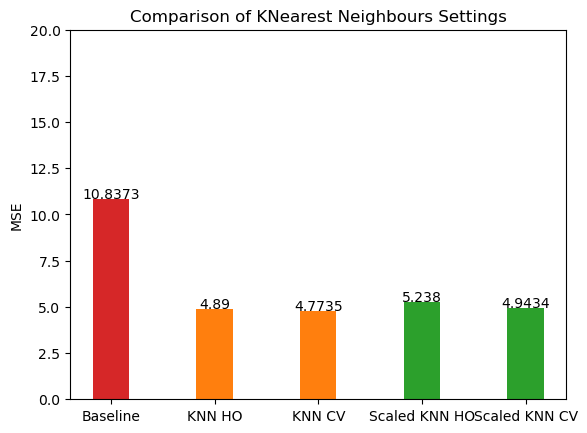

In [66]:
import numpy as np
import matplotlib.pyplot as plt


# Set labels and scores for each regressor
labels = ['Baseline', 'KNN HO', 'KNN CV', 'Scaled KNN HO', 'Scaled KNN CV']
mse_scores = [mse_baseline, mse_score_knn, mean_test_mse_knn, mse_score_knn_scaled, mean_test_mse_knn_scaled]


# Create bar chart
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x, mse_scores, width, label='MSE', color=['tab:red', 'tab:orange', 'tab:orange', 'tab:green', 'tab:green'])

# Add exact values of each bar to the top of the bars
for i, v in enumerate(mse_scores):
    ax.text(i, v + 0.05, str(round(v, 4)), ha='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('Comparison of KNearest Neighbours Settings')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Adjust y-axis scale
ax.set_ylim([0, 20])

# Save and show the plot
plt.savefig('../results/abalone_age/knn_comparison_mse.png')
plt.show()


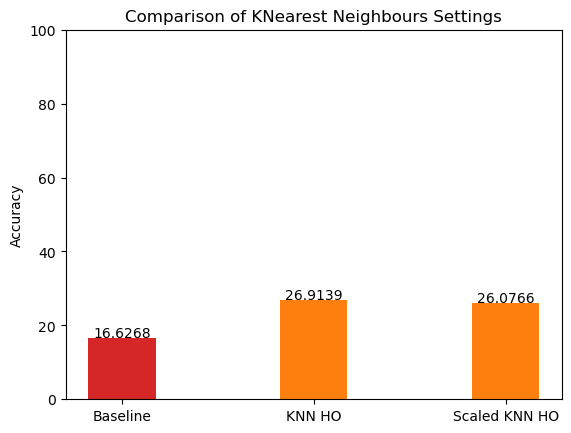

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Set labels and scores for each regressor
labels = ['Baseline', 'KNN HO', 'Scaled KNN HO']
accuracy_scores = [accuracy_baseline, accuracy_score_knn, accuracy_score_knn_scaled]


# Create bar chart
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x, accuracy_scores, width, label='Accuracy', color=['tab:red', 'tab:orange', 'tab:orange'])

# Add exact values of each bar to the top of the bars
for i, v in enumerate(accuracy_scores):
    ax.text(i, v + 0.05, str(round(v, 4)), ha='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of KNearest Neighbours Settings')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Adjust y-axis scale
ax.set_ylim([0, 100])

# Save and show the plot
plt.savefig('../results/abalone_age/knn_comparison_acc.png')
plt.show()


## Neural Networks

### Base NN

In [68]:
def create_model(units=0, activation='', optimizer=''):
    model = Sequential()
    model.add(Dense(units, input_dim=X_train.shape[1], activation=activation))
    model.add(Dense(units//2, activation=activation))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
    return model

model = KerasRegressor(build_fn=create_model, verbose=2)


In [69]:
# param_distributions_nn = {
#     'units': [32, 64, 128],
#     'activation': ['relu', 'sigmoid', 'tanh'],
#     'optimizer': ['adam', 'rmsprop', 'sgd']
# }

# param_distributions_nn = {
#     'units': [16, 32, 64, 128, 256],
#     'activation': ['tanh', 'relu'],
#     'optimizer': ['sgd']
# }

# param_distributions_nn = {
#     'units': [16, 32, 64],
#     'activation': ['relu'],
#     'optimizer': ['adam', 'rmsprop', 'sgd']
# }

param_distributions_nn = {
    'units': [8, 16, 32, 64, 128, 256, 512, 1024],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'optimizer': ['adam', 'rmsprop', 'sgd']
}

# param_distributions_nn = {
#     'units': [8, 16, 32],
#     'activation': ['relu'],
#     'optimizer': ['adam', 'rmsprop', 'sgd']
# }


In [70]:
grid = RandomizedSearchCV(estimator=model, param_distributions=param_distributions_nn, cv=5, random_state=42, scoring='neg_mean_squared_error')


In [71]:
grid_result = grid.fit(X_train, y_train)

84/84 - 1s - loss: 46.2819 - mean_squared_error: 46.2819 - 584ms/epoch - 7ms/step
21/21 - 0s - 71ms/epoch - 3ms/step
84/84 - 1s - loss: 39.4264 - mean_squared_error: 39.4264 - 511ms/epoch - 6ms/step
21/21 - 0s - 49ms/epoch - 2ms/step
84/84 - 1s - loss: 39.2295 - mean_squared_error: 39.2295 - 507ms/epoch - 6ms/step
21/21 - 0s - 48ms/epoch - 2ms/step
84/84 - 1s - loss: 39.8839 - mean_squared_error: 39.8839 - 515ms/epoch - 6ms/step
21/21 - 0s - 49ms/epoch - 2ms/step
84/84 - 1s - loss: 46.3738 - mean_squared_error: 46.3738 - 510ms/epoch - 6ms/step
21/21 - 0s - 50ms/epoch - 2ms/step
84/84 - 1s - loss: 9.9361 - mean_squared_error: 9.9361 - 582ms/epoch - 7ms/step
21/21 - 0s - 55ms/epoch - 3ms/step
84/84 - 0s - loss: 9.5700 - mean_squared_error: 9.5700 - 446ms/epoch - 5ms/step
21/21 - 0s - 55ms/epoch - 3ms/step
84/84 - 0s - loss: 8.8326 - mean_squared_error: 8.8326 - 440ms/epoch - 5ms/step
21/21 - 0s - 53ms/epoch - 3ms/step
84/84 - 0s - loss: 8.9756 - mean_squared_error: 8.9756 - 436ms/epoch -

In [72]:
scores_nn = pd.DataFrame(grid_result.cv_results_)
scores_nn = scores_nn.sort_values(by=['rank_test_score']).reset_index(drop='index')

mean_test_nn = abs(scores_nn.head(1)['mean_test_score'].values[0])
scores_nn.style.hide_index()


mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_units,param_optimizer,param_activation,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0.706711,0.088083,0.095744,0.002361,512,adam,tanh,"{'units': 512, 'optimizer': 'adam', 'activation': 'tanh'}",-5.541387,-7.509619,-7.550305,-6.834179,-6.525884,-6.792275,0.738462,1
0.541153,0.061119,0.091156,0.001197,512,rmsprop,tanh,"{'units': 512, 'optimizer': 'rmsprop', 'activation': 'tanh'}",-5.807009,-7.870799,-7.790819,-8.027666,-7.049654,-7.309189,0.823102,2
0.453588,0.003806,0.083377,0.000488,128,rmsprop,relu,"{'units': 128, 'optimizer': 'rmsprop', 'activation': 'relu'}",-6.241821,-8.015421,-8.253224,-7.504400,-7.081437,-7.419260,0.715352,3
0.607575,0.053783,0.092352,0.013180,128,adam,relu,"{'units': 128, 'optimizer': 'adam', 'activation': 'relu'}",-6.361667,-8.278650,-8.497284,-7.503710,-8.469216,-7.822105,0.814531,4
0.409705,0.003752,0.085371,0.002721,32,sgd,relu,"{'units': 32, 'optimizer': 'sgd', 'activation': 'relu'}",-12.363495,-10.958007,-7.447560,-8.466791,-8.017802,-9.450731,1.886276,5
0.637895,0.040988,0.094346,0.005870,128,adam,sigmoid,"{'units': 128, 'optimizer': 'adam', 'activation': 'sigmoid'}",-17.612711,-31.291121,-18.072589,-22.690561,-12.727034,-20.478803,6.259271,6
0.541553,0.076079,0.091952,0.006160,32,rmsprop,relu,"{'units': 32, 'optimizer': 'rmsprop', 'activation': 'relu'}",-35.004414,-36.828904,-21.081152,-33.807176,-15.931220,-28.530573,8.400631,7
0.620341,0.052182,0.088165,0.005662,32,adam,tanh,"{'units': 32, 'optimizer': 'adam', 'activation': 'tanh'}",-33.881779,-28.962120,-39.666544,-36.413837,-25.935386,-32.971933,4.961531,8
0.459372,0.013538,0.085371,0.000489,32,rmsprop,sigmoid,"{'units': 32, 'optimizer': 'rmsprop', 'activation': 'sigmoid'}",-72.656631,-50.987375,-90.339968,-59.909051,-80.264823,-70.831570,14.042708,9
0.652257,0.139767,0.087765,0.002359,8,adam,relu,"{'units': 8, 'optimizer': 'adam', 'activation': 'relu'}",-84.993177,-80.682045,-98.949929,-103.503601,-90.518608,-91.729472,8.481210,10


In [73]:
top_n = len(scores_nn)
runtimes = scores_nn[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']].iloc[:top_n]
runtimes['rank'] = range(1, top_n + 1)
runtimes = runtimes.set_index('rank')
print(runtimes)


      mean_fit_time  std_fit_time  mean_score_time  std_score_time
rank                                                              
1          0.706711      0.088083         0.095744        0.002361
2          0.541153      0.061119         0.091156        0.001197
3          0.453588      0.003806         0.083377        0.000488
4          0.607575      0.053783         0.092352        0.013180
5          0.409705      0.003752         0.085371        0.002721
6          0.637895      0.040988         0.094346        0.005870
7          0.541553      0.076079         0.091952        0.006160
8          0.620341      0.052182         0.088165        0.005662
9          0.459372      0.013538         0.085371        0.000489
10         0.652257      0.139767         0.087765        0.002359


In [74]:
# Get the best hyperparameter set and the top 10 hyperparameter sets
best_params = grid_result.best_params_
top_params = grid_result.cv_results_['params'][:10]

# Train a new model for each of the top 10 hyperparameter sets
histories = []
for params in top_params:
    model = create_model(units=params['units'], activation=params['activation'], optimizer=params['optimizer'])
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
    histories.append(history)
    
    
for history in histories:
    print(history.model.layers[0].get_config()['activation'])
    print(history.model.layers[0].get_config()['units'])      
    print(history.model.layers[1].get_config()['units'])     
    print(history.model.layers[2].get_config()['units']) 
    # Get the model's predictions on the test data
    y_pred = history.model.predict(X_test)
    
    # Round the predicted values
    y_pred_rounded = [int(np.round(val)) for val in y_pred]
    
    # Calculate the accuracy score
    acc_score = accuracy_score(y_test, y_pred_rounded)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred_rounded)
    
    # Print the scores for this model
    print("Accuracy score: ", acc_score)
    print("Mean squared error: ", mse)

Epoch 1/50
105/105 [==============================] - 1s 2ms/step - loss: 34.4154 - mean_squared_error: 34.4154 - val_loss: 7.4825 - val_mean_squared_error: 7.4825
Epoch 2/50
105/105 [==============================] - 0s 1ms/step - loss: 7.1494 - mean_squared_error: 7.1494 - val_loss: 6.8366 - val_mean_squared_error: 6.8366
Epoch 3/50
105/105 [==============================] - 0s 1ms/step - loss: 6.7035 - mean_squared_error: 6.7035 - val_loss: 6.5347 - val_mean_squared_error: 6.5347
Epoch 4/50
105/105 [==============================] - 0s 1ms/step - loss: 6.3417 - mean_squared_error: 6.3417 - val_loss: 6.3268 - val_mean_squared_error: 6.3268
Epoch 5/50
105/105 [==============================] - 0s 1ms/step - loss: 6.0885 - mean_squared_error: 6.0885 - val_loss: 5.9590 - val_mean_squared_error: 5.9590
Epoch 6/50
105/105 [==============================] - 0s 1ms/step - loss: 5.7753 - mean_squared_error: 5.7753 - val_loss: 5.6962 - val_mean_squared_error: 5.6962
Epoch 7/50
105/105 [======

Epoch 1/50
105/105 - 1s - loss: 11.9865 - mean_squared_error: 11.9865 - val_loss: 6.6211 - val_mean_squared_error: 6.6211 - 711ms/epoch - 7ms/step
Epoch 2/50
105/105 - 0s - loss: 6.3197 - mean_squared_error: 6.3197 - val_loss: 6.1259 - val_mean_squared_error: 6.1259 - 184ms/epoch - 2ms/step
Epoch 3/50
105/105 - 0s - loss: 5.6794 - mean_squared_error: 5.6794 - val_loss: 5.6478 - val_mean_squared_error: 5.6478 - 187ms/epoch - 2ms/step
Epoch 4/50
105/105 - 0s - loss: 5.1787 - mean_squared_error: 5.1787 - val_loss: 5.5696 - val_mean_squared_error: 5.5696 - 187ms/epoch - 2ms/step
Epoch 5/50
105/105 - 0s - loss: 5.0462 - mean_squared_error: 5.0462 - val_loss: 5.3049 - val_mean_squared_error: 5.3049 - 185ms/epoch - 2ms/step
Epoch 6/50
105/105 - 0s - loss: 4.9625 - mean_squared_error: 4.9625 - val_loss: 5.0621 - val_mean_squared_error: 5.0621 - 189ms/epoch - 2ms/step
Epoch 7/50
105/105 - 0s - loss: 4.8715 - mean_squared_error: 4.8715 - val_loss: 5.1698 - val_mean_squared_error: 5.1698 - 187ms/

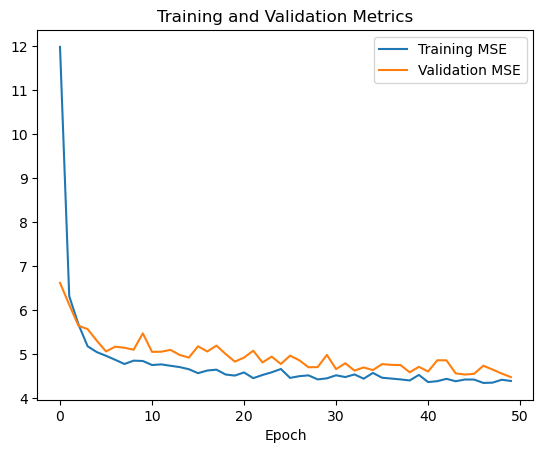

In [75]:
# Get the best model from grid search
best_model = grid_result.best_estimator_


# Train the model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Plot the training and validation mse for each epoch
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.xlabel('Epoch')
plt.title('Training and Validation Metrics')
plt.legend()

# Save and show the plot
plt.savefig('../results/abalone_age/nn_best_training_mse.png')
plt.show()


In [76]:
y_pred = best_model.predict(X_test)

# Round the predicted values
y_pred_rounded = [int(np.round(val)) for val in y_pred]

# Compare the actual and predicted values
table = pd.DataFrame({'Actual_y_value':y_test, 'Predicted_y_value':y_pred_rounded})

accuracy_score_nn = accuracy_score(y_test, y_pred_rounded)*100
print("Accuracy of neural network is:")
print(accuracy_score_nn)

mse_score_nn = mean_squared_error(y_test, y_pred_rounded)
print("MSE of neural network is:")
print(mse_score_nn)

27/27 - 0s - 59ms/epoch - 2ms/step
Accuracy of neural network is:
25.0
MSE of neural network is:
4.55622009569378


In [77]:
table

,Actual_y_value,Predicted_y_value
866,9,12
1483,8,10
599,16,15
1702,9,11
670,14,12
...,...,...
3093,11,11
1651,8,10
2897,10,9
3953,8,9


### Scaling

In [78]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Convert NumPy arrays to Pandas DataFrames
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# # Save preprocessed and scaled data as CSV files
# X_train_scaled_df.to_csv('../data/abalone_age/abalone_X_train_preprocessed_scaled.csv', index=False)
# X_test_scaled_df.to_csv('../data/abalone_age/abalone_X_test_preprocessed_scaled.csv', index=False)


In [79]:
def create_model_scaled(units=0, activation='', optimizer=''):
    model = Sequential()
    model.add(Dense(units, input_dim=X_train_scaled.shape[1], activation=activation))
    model.add(Dense(units//2, activation=activation))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


In [80]:
model = KerasRegressor(build_fn=create_model_scaled, verbose=1)


In [81]:
grid = RandomizedSearchCV(estimator=model, param_distributions=param_distributions_nn, cv=5, random_state=42, scoring='neg_mean_squared_error')


In [82]:
grid_result = grid.fit(X_train_scaled, y_train)

105/105 [==============================] - 1s 2ms/step - loss: 30.3553


In [83]:
scores_nn_scaled = pd.DataFrame(grid_result.cv_results_)
scores_nn_scaled = scores_nn_scaled.sort_values(by=['rank_test_score']).reset_index(drop='index')

mean_test_nn_scaled = abs(scores_nn_scaled.head(1)['mean_test_score'].values[0])

scores_nn_scaled.head(10)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_units,param_optimizer,param_activation,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.622336,0.015668,0.086767,0.000892,512,adam,tanh,"{'units': 512, 'optimizer': 'adam', 'activatio...",-4.356065,-5.474929,-5.249972,-4.696600,-4.387551,-4.833024,0.453968,1
1,0.377590,0.001850,0.081980,0.003960,32,sgd,relu,"{'units': 32, 'optimizer': 'sgd', 'activation'...",-4.779910,-6.329672,-6.402995,-6.004035,-4.636987,-5.630720,0.766249,2
2,0.472336,0.095452,0.081782,0.005536,128,rmsprop,relu,"{'units': 128, 'optimizer': 'rmsprop', 'activa...",-7.769241,-8.165786,-8.184098,-6.691304,-9.851201,-8.132326,1.016534,3
3,0.527789,0.075110,0.090358,0.006003,512,rmsprop,tanh,"{'units': 512, 'optimizer': 'rmsprop', 'activa...",-6.372617,-12.181064,-10.392093,-5.907459,-6.893651,-8.349377,2.483715,4
4,0.590621,0.046199,0.088164,0.009945,128,adam,relu,"{'units': 128, 'optimizer': 'adam', 'activatio...",-9.599469,-12.927858,-13.070928,-11.944055,-11.148543,-11.738171,1.277160,5
5,0.542151,0.002999,0.124866,0.090161,128,adam,sigmoid,"{'units': 128, 'optimizer': 'adam', 'activatio...",-9.945910,-13.527605,-27.880726,-23.655245,-14.449866,-17.891871,6.738341,6
6,0.418481,0.005938,0.079787,0.001093,32,rmsprop,relu,"{'units': 32, 'optimizer': 'rmsprop', 'activat...",-34.417552,-47.445137,-53.376596,-46.559122,-44.411212,-45.241924,6.174450,7
7,0.419678,0.005726,0.080385,0.000799,32,rmsprop,sigmoid,"{'units': 32, 'optimizer': 'rmsprop', 'activat...",-61.298534,-79.929115,-57.350742,-65.758352,-42.494229,-61.366194,12.133858,8
8,0.536366,0.001596,0.080385,0.001196,32,adam,tanh,"{'units': 32, 'optimizer': 'adam', 'activation...",-74.596231,-82.268385,-83.531001,-87.609072,-85.020494,-82.605036,4.381473,9
9,0.538959,0.004575,0.079388,0.001017,8,adam,relu,"{'units': 8, 'optimizer': 'adam', 'activation'...",-73.536714,-79.667965,-108.244603,-90.543326,-80.434769,-86.485475,12.171160,10


In [84]:
top_n = 10
runtimes = scores_nn_scaled[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']].iloc[:top_n]
runtimes['rank'] = range(1, top_n + 1)
runtimes = runtimes.set_index('rank')
print(runtimes)


      mean_fit_time  std_fit_time  mean_score_time  std_score_time
rank                                                              
1          0.622336      0.015668         0.086767        0.000892
2          0.377590      0.001850         0.081980        0.003960
3          0.472336      0.095452         0.081782        0.005536
4          0.527789      0.075110         0.090358        0.006003
5          0.590621      0.046199         0.088164        0.009945
6          0.542151      0.002999         0.124866        0.090161
7          0.418481      0.005938         0.079787        0.001093
8          0.419678      0.005726         0.080385        0.000799
9          0.536366      0.001596         0.080385        0.001196
10         0.538959      0.004575         0.079388        0.001017


Epoch 1/50
105/105 [==============================] - 1s 3ms/step - loss: 30.7794 - val_loss: 5.5427
Epoch 2/50
105/105 [==============================] - 0s 2ms/step - loss: 4.9096 - val_loss: 5.2704
Epoch 3/50
105/105 [==============================] - 0s 2ms/step - loss: 4.9786 - val_loss: 5.7609
Epoch 4/50
105/105 [==============================] - 0s 2ms/step - loss: 4.8379 - val_loss: 5.1929
Epoch 5/50
105/105 [==============================] - 0s 2ms/step - loss: 4.8821 - val_loss: 5.0643
Epoch 6/50
105/105 [==============================] - 0s 2ms/step - loss: 4.6592 - val_loss: 5.0226
Epoch 7/50
105/105 [==============================] - 0s 2ms/step - loss: 4.7005 - val_loss: 5.3322
Epoch 8/50
105/105 [==============================] - 0s 2ms/step - loss: 4.7037 - val_loss: 5.3958
Epoch 9/50
105/105 [==============================] - 0s 2ms/step - loss: 4.7212 - val_loss: 5.5434
Epoch 10/50
105/105 [==============================] - 0s 2ms/step - loss: 4.6905 - val_loss: 5.114

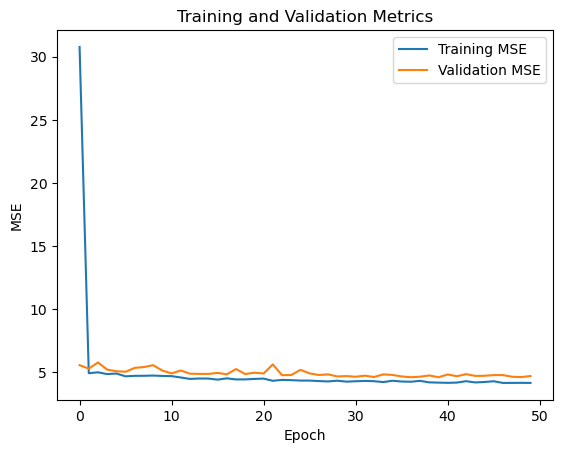

In [85]:
# Get the best model from grid search
best_model = grid_result.best_estimator_

# Train the model
history = best_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

# Plot the training and validation mse for each epoch
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation Metrics')
plt.legend()

# Save and show the plot
plt.savefig('../results/abalone_age/nn_scaled_best_training_mse.png')
plt.show()


In [86]:
# Get the best hyperparameter set and the top 10 hyperparameter sets
best_params = grid_result.best_params_
top_params = grid_result.cv_results_['params'][:10]

# Train a new model for each of the top 10 hyperparameter sets
histories = []
for params in top_params:
    model = create_model(units=params['units'], activation=params['activation'], optimizer=params['optimizer'])
    history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))
    histories.append(history)
    
    
for history in histories:
    print(history.model.layers[0].get_config()['activation'])
    print(history.model.layers[0].get_config()['units'])      
    print(history.model.layers[1].get_config()['units'])     
    print(history.model.layers[2].get_config()['units'])      
    # Get the model's predictions on the test data
    y_pred = history.model.predict(X_test_scaled)
    
    # Round the predicted values
    y_pred_rounded = [int(np.round(val)) for val in y_pred]
    
    # Calculate the accuracy score
    acc_score = accuracy_score(y_test, y_pred_rounded)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred_rounded)
    
    # Print the scores for this model
    print("Accuracy score: ", acc_score)
    print("Mean squared error: ", mse)

Epoch 1/50
105/105 [==============================] - 1s 2ms/step - loss: 37.8629 - mean_squared_error: 37.8629 - val_loss: 8.2859 - val_mean_squared_error: 8.2859
Epoch 2/50
105/105 [==============================] - 0s 1ms/step - loss: 6.1789 - mean_squared_error: 6.1789 - val_loss: 5.5063 - val_mean_squared_error: 5.5063
Epoch 3/50
105/105 [==============================] - 0s 1ms/step - loss: 5.1638 - mean_squared_error: 5.1638 - val_loss: 5.2116 - val_mean_squared_error: 5.2116
Epoch 4/50
105/105 [==============================] - 0s 1ms/step - loss: 4.9279 - mean_squared_error: 4.9279 - val_loss: 5.0649 - val_mean_squared_error: 5.0649
Epoch 5/50
105/105 [==============================] - 0s 1ms/step - loss: 4.7919 - mean_squared_error: 4.7919 - val_loss: 4.9536 - val_mean_squared_error: 4.9536
Epoch 6/50
105/105 [==============================] - 0s 1ms/step - loss: 4.7001 - mean_squared_error: 4.7001 - val_loss: 4.9207 - val_mean_squared_error: 4.9207
Epoch 7/50
105/105 [======

In [87]:
y_pred = best_model.predict(X_test_scaled)

# Round the predicted values
y_pred_rounded = [int(np.round(val)) for val in y_pred]

# Compare the actual and predicted values
table = pd.DataFrame({'Actual_y_value':y_test, 'Predicted_y_value':y_pred_rounded})

accuracy_score_nn_scaled = accuracy_score(y_test, y_pred_rounded)*100
print("Accuracy of neural network is:")
print(accuracy_score_nn_scaled)

mse_score_nn_scaled = mean_squared_error(y_test, y_pred_rounded)
print("MSE of neural network is:")
print(mse_score_nn_scaled)

27/27 [==============================] - 0s 1ms/step
Accuracy of neural network is:
24.04306220095694
MSE of neural network is:
4.813397129186603


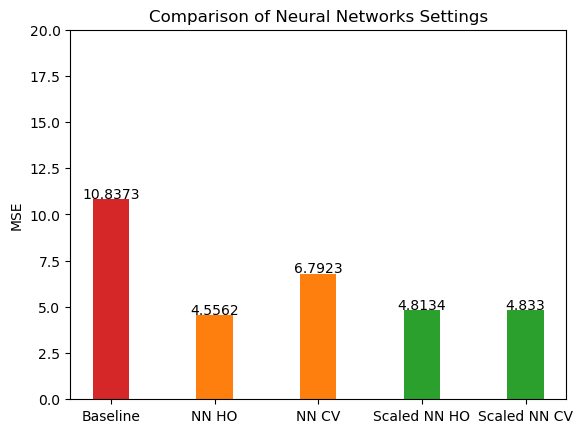

In [88]:
import numpy as np
import matplotlib.pyplot as plt


labels = ['Baseline', 'NN HO', 'NN CV', 'Scaled NN HO', 'Scaled NN CV']
mse_scores = [mse_baseline, mse_score_nn, mean_test_nn, mse_score_nn_scaled, mean_test_nn_scaled]


# Create bar chart
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x, mse_scores, width, color=['tab:red', 'tab:orange', 'tab:orange', 'tab:green', 'tab:green'])

# Add exact values of each bar to the top of the bars
for i, v in enumerate(mse_scores):
    ax.text(i, v + 0.05, str(round(v, 4)), ha='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('Comparison of Neural Networks Settings')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Adjust y-axis scale
ax.set_ylim([0, 20])

# Save and show the plot
plt.savefig('../results/abalone_age/nn_comparison_mse.png')
plt.show()


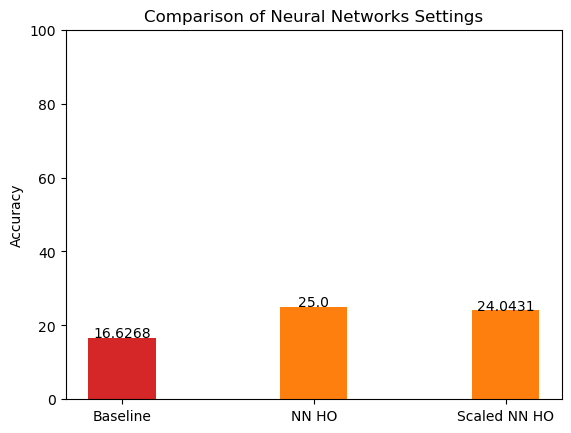

In [89]:
import numpy as np
import matplotlib.pyplot as plt


labels = ['Baseline', 'NN HO', 'Scaled NN HO']
accuracy_scores = [accuracy_baseline, accuracy_score_nn, accuracy_score_nn_scaled]


# Create bar chart
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x, accuracy_scores, width, label='Accuracy', color=['tab:red', 'tab:orange', 'tab:orange', 'tab:green', 'tab:green'])

# Add exact values of each bar to the top of the bars
for i, v in enumerate(accuracy_scores):
    ax.text(i, v + 0.05, str(round(v, 4)), ha='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Neural Networks Settings')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Adjust y-axis scale
ax.set_ylim([0, 100])

# Save and show the plot
plt.savefig('../results/abalone_age/nn_comparison_acc.png')
plt.show()


# Final comparison results

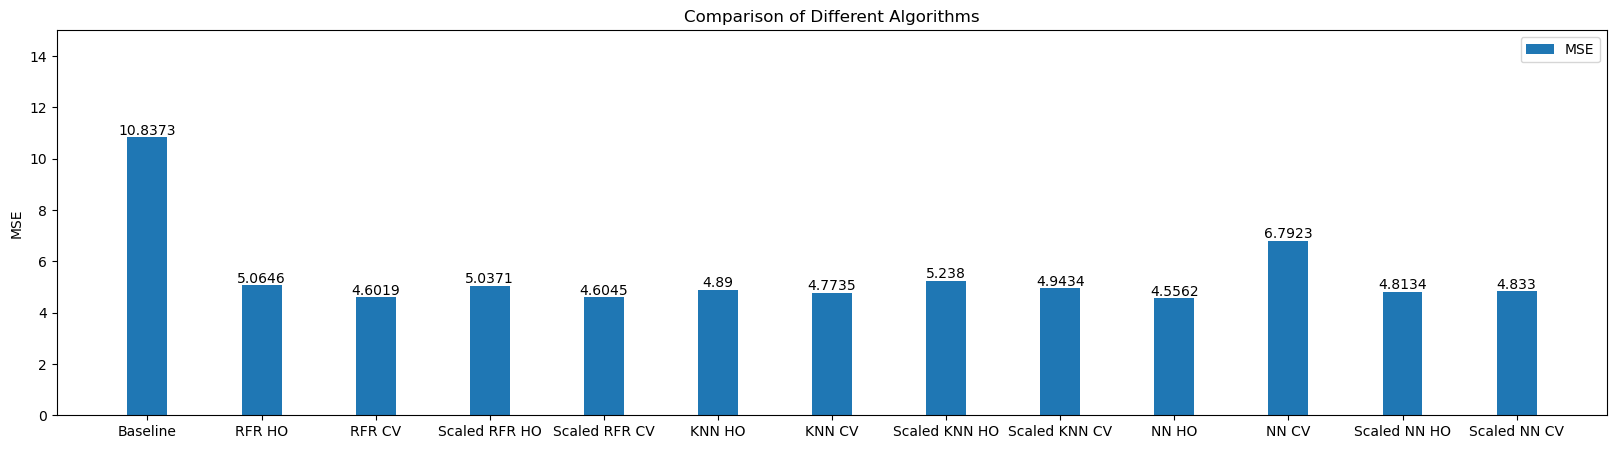

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Create figure with a single subplot
fig, ax = plt.subplots(figsize=(20, 5))

# Set labels and scores for each regressor
labels = ['Baseline', 'RFR HO', 'RFR CV', 'Scaled RFR HO', 'Scaled RFR CV',
          'KNN HO', 'KNN CV', 'Scaled KNN HO', 'Scaled KNN CV',
          'NN HO', 'NN CV', 'Scaled NN HO', 'Scaled NN CV']
mse_scores = [mse_baseline, mse_score_rf, mean_test_mse_rfr, mse_score_rf_scaled, mean_test_mse_rfr_scaled,
                    mse_score_knn, mean_test_mse_knn, mse_score_knn_scaled, mean_test_mse_knn_scaled,
                    mse_score_nn, mean_test_nn, mse_score_nn_scaled, mean_test_nn_scaled]

# Set positions and widths of the bars
x = np.arange(len(labels))
width = 0.35

# Plot the bars and add exact values to the top of each bar
rects1 = ax.bar(x, mse_scores, width, label='MSE')
for i, v in enumerate(mse_scores):
    ax.text(i, v + 0.1, str(round(v, 4)), ha='center')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('MSE')
ax.set_title('Comparison of Different Algorithms')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adjust y-axis scale
ax.set_ylim([0, 15])

# Save and show the plot
plt.savefig('../results/abalone_age/final_comparison_all_mse.png')
plt.show()


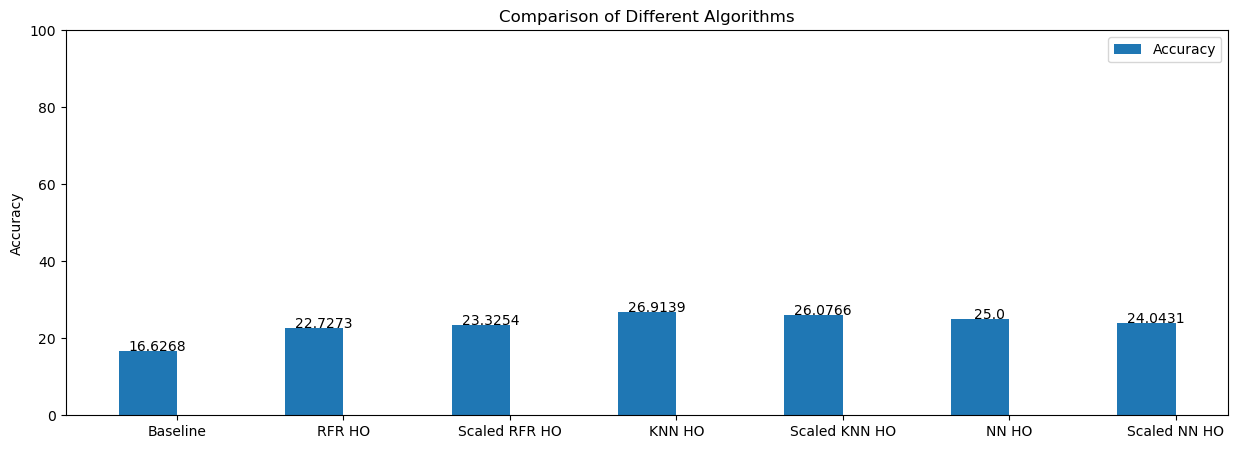

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Create figure with a single subplot
fig, ax = plt.subplots(figsize=(15, 5))

# Set labels and scores for each regressor
labels = ['Baseline', 'RFR HO', 'Scaled RFR HO', 'KNN HO', 'Scaled KNN HO', 'NN HO', 'Scaled NN HO']
accuracy_scores = [accuracy_baseline, accuracy_score_rf, accuracy_score_rf_scaled, accuracy_score_knn, accuracy_score_knn_scaled, accuracy_score_nn, accuracy_score_nn_scaled]

# Set positions and widths of the bars
x = np.arange(len(labels))
width = 0.35

# Plot the bars and add exact values to the top of each bar
rects1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy')
for i, v in enumerate(accuracy_scores):
    ax.text(i - width/3, v + 0.05, str(round(v, 4)), ha='center')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Different Algorithms')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adjust y-axis scale
ax.set_ylim([0, 100])

# Save and show the plot
plt.savefig('../results/abalone_age/final_comparison_all_acc.png')
plt.show()
